In [211]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [212]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [213]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [214]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [215]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [216]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [217]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [218]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [219]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [220]:
#look at columns for measurement

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [221]:
#look at columns for station
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [222]:
#added this line of code to figure out the "start date" for Flask
first_date = session.query(Measurement.date).order_by(Measurement.date).first()
print(first_date)

('2010-01-01',)


In [223]:
# Find the most recent date in the data set. (using 'measurement since station does not have a date column')
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


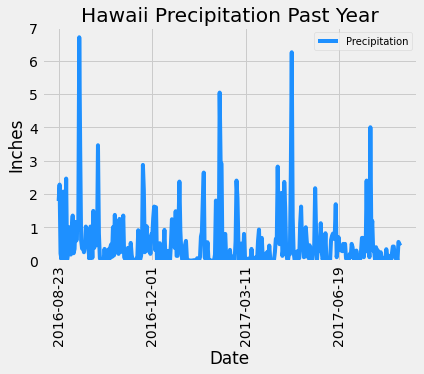

In [235]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017, 8, 23) -dt.timedelta(days=365)
# print(one_year)-checked to make sure this worked

# Perform a query to retrieve the data and precipitation scores

data_precipitation = session.query(Measurement.date, func.max(Measurement.prcp)).\
    filter(Measurement.date >= one_year).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

# data_precipitation
#noticed some of the dates had none when I ran this code so will add dropna to remove those without data
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(data_precipitation, columns=['Date', 'Precipitation'])
precipitation_df = precipitation_df.dropna(how='any')
# precipitation_df.head(40)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(["Date"])
# precipitation_df.head(15)

# Use Pandas Plotting with Matplotlib to plot the data

df = pd.DataFrame(precipitation_df, columns=["Date", "Precipitation"])
df.set_index("Date", inplace=True)
df.plot(color= "dodgerblue", ylim = (0,7), rot = 90)
plt.legend(loc='upper right', fontsize="10")
plt.title("Hawaii Precipitation Past Year")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()


In [225]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


# Exploratory Station Analysis

In [226]:
# Design a query to calculate the total number stations in the dataset
# session.query(Station.station).count()

stations = session.query(Station).\
    filter(Station.id).count()
    
print(f"There are {stations} stations")

There are 9 stations


In [227]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
print(active_stations)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [228]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#USC00519281 was the most active station

temperatures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == "USC00519281").all()
                             
print(f"Lowest temp: {temperatures[0][0]}") 
print(f"Highest temp: {temperatures[0][1]}") 
print(f"Average temp:{temperatures[0][2]}")

Lowest temp: 54.0
Highest temp: 85.0
Average temp:71.66378066378067


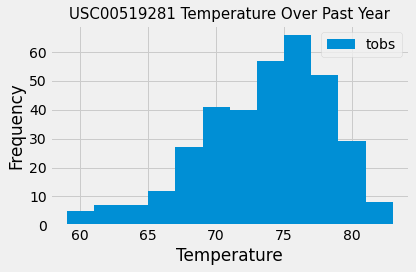

In [229]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date > "2016-08-23").\
    order_by(Measurement.date).all()
# print(temp_obs)

temperature_df = pd.DataFrame(temp_obs)
temperature_df.set_index('station', inplace=True)
temperature_df.plot.hist(bins=12)
plt.title("USC00519281 Temperature Over Past Year", fontsize="15")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Close session

In [230]:
# Close Session
session.close()